In [4]:
%matplotlib inline
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
import _spin_params as spin_pars
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
# matplotlib.pyplot.switch_backend('nbagg')
# %qtconsole

In [5]:
q = spin_pars.q
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)

In [144]:
def pulse_chirped(t, args, ichannel=True):
    tau = args[0]
    tend = args[1]
    t0 = tend/2
    alpha = args[2]
    if ichannel:
        return np.cos(np.abs(t-t0)**2*alpha)*np.exp(-(t-t0)**2/(2*tau**2))
    else:
        return np.sin(np.abs(t-t0)**2*alpha)*np.exp(-(t-t0)**2/(2*tau**2))

In [7]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

Text(0, 0.5, 'weight')

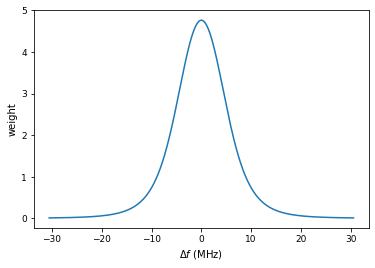

In [167]:
spins, pdf = create_spins_nocav(
    q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf*nbins)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
# %qtconsole

# SOC pulses

In [168]:
pumptime = 600e-3  # 5*np.pi/gcoll
decaytime = 2000e-3
dt = 0.004
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.zeros(len(spins)*2)
init[1::2] = -1

### Calibrate power

In [177]:
# pin = np.arange(-30, 0, 1)
aref = 20

szlos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(szlos))
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    solpump, soldecay, infodict = solve_obes(
        obes, init, pdf, tlist, tlistdecay, dr, 1, gperp, spins, gpar)
    szlos[ctr, :] = np.hstack((np.real(np.sum(solpump[:, 1::2], axis=1)), np.real(
        np.sum(soldecay[:, 1::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(solpump[:, 1::2]), np.real(soldecay[:, 1::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(solpump[:, ::2]), np.real(soldecay[:, ::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(solpump[:, ::2], axis=1)), np.real(
        np.sum(soldecay[:, ::2], axis=1))))

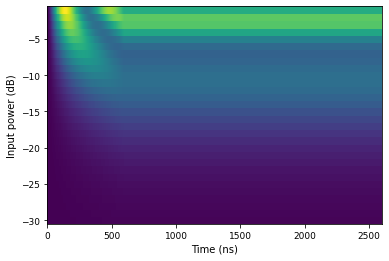

In [178]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
#fig, (ax2) = plt.subplots(1,1, figsize=(15,5))
fig = plt.figure()
plt.pcolor(tplot, pin, szlos, shading="auto")
plt.xlabel('Time (ns)')
plt.ylabel('Input power (dB)');

In [181]:
tend = 400e-3
tp = np.arange(0, tend+dt, dt)
tplot2 = np.linspace(0, 1000*(pumptime+decaytime), len(tp)+len(tlistdecay))


dtf = 0.0001
tpf = np.arange(0, pumptime+dtf, dtf)

tau = tend/6
alpha = 8*gammaq/tend/2  # sweeps from -8 linewidth to 8* linewidth

# %qtconsole
pulsei = pulse_chirped(tp, (tau, tend, alpha), True)
pulseq = pulse_chirped(tp, (tau, tend, alpha), False)

scale = 80
solutionpump2, soldecay, infodict = solve_obes(
    obes_soc, init, pdf, tp, tlistdecay, scale*pulsei, scale*pulseq, tp, 1, gperp, spins, gpar)

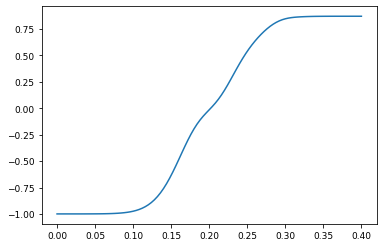

In [182]:
plt.plot(tp, np.sum(np.real(solutionpump2[:, 1::2]), axis=1))